# Solving AWE Using PINN

## Problem Equation
Equation to solve for:
$$\frac {\partial^2p}{\partial t^2} = c^2\ \nabla^2p + f(x, y, t), \quad x,\ y,\ t \in [0, 1]$$

Where

- $\nabla^2 p = \frac {\partial^2 p} {\partial x^2} + \frac {\partial^2 p} {\partial y^2}$
- $c$ is the speed of sound
- $f(x, y, t)$ is a source term

**We are solving for $p$**

## Conditions
### Boundary Conditions
$$p(x, y, t) = 0  \text{ for all points where } x \in \{0, 1\} \text{ and } y \in \{0, 1\}$$

### Initial Condition
#### Pressure field at $t = 0$
$$p(x, y, 0) = \sin(\pi x)\sin(\pi y)$$

#### Time derivative of Pressure Field at $t = 0$
$$\frac {\partial p}{\partial t}(x, y, 0) = 0$$

## Loss Function
Since initial conditions and boundary conditions are hard enforced, the loss function is only concerned with PDE residual

$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \left[ \frac{\partial^2 \hat{p}}{\partial t^2}(x_i, y_i, t_i) - c^2 \left( \frac{\partial^2 \hat{p}}{\partial x^2}(x_i, y_i, t_i) + \frac{\partial^2 \hat{p}}{\partial y^2}(x_i, y_i, t_i) \right) - f(x_i, y_i, t_i) \right]^2
$$

# Code

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

## Defining the Model

In [2]:
class PINN(nn.Module):
    def __init__(self, hidden_layers, trial_solution, samples = [256, 64, 64], input_domain=None, activation=nn.Tanh, 
                 source_fxn=None, true_solution=None, c=1.0, retrain_seed=42):
        '''
        Model to solve Acoustic Wave Equation. Accepts 3 dimension input x, y and t. 

        Args:
            hidden_layers (list): Number of neurons in each hidden layer
            trial_solution (fxn): Function to enforce hard boundary
            samples (list): Number of sample points to generate for interior, spatial boundary and temporal boundary
            input_domain (torch.tensor): 2D tensor storing the lower and upper bound of each dimension
            activation (fxn): Activation function to apply to each layer
            source_fxn (fxn): Source where wave originates from. Can be None
            c (float): Speed of wave
            retrain_seed (int): Seed for torch.manual_seed()

        Attributes:
            output_dimensions (int): Number of neurons in output layer
            training_set (torch.tensor): A 2D tensor of training points
       '''
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_domain = input_domain
        self.output_dimension = 1
        self.activation = activation
        self.c = c
        self.trial_solution = lambda x, y, t: trial_solution(x, y, t, self.net, self.device)
        self.source_fxn = None
        self.true_solution = None
        self.loss_history = []

        # Defining input_domain if not provided
        if self.input_domain is None:
            self.input_domain = torch.tensor([[0, 1],    # x
                                              [0, 1],    # y
                                              [0, 1]])   # t
        
        # Attaching the source_fxn to model if given
        if source_fxn is not None:
            self.source_fxn = lambda x, y, t: source_fxn(x, y, t, self.device)

        # Attaching the true solution to model if given
        if true_solution is not None:
            self.true_solution = lambda x, y, t: true_solution(x, y, t, self.c, self.device)

        # Creating a Sobol Engine to generate sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.input_domain.shape[0])
        

        torch.manual_seed(retrain_seed)
        self.net = self.create_model(hidden_layers)
        self.training_set_int, self.training_set_sb, self.training_set_tb = self.assemble_dataset(samples)
        
        # Moving the model and tensors to device
        self.to(self.device)
        self.training_set_int = self.training_set_int.to(self.device)
        self.training_set_sb = self.training_set_sb.to(self.device)
        self.training_set_tb = self.training_set_tb.to(self.device)
        

    def forward(self, x):
        return self.net(x)
    
    def create_model(self, hidden_layers):
        '''
        Defines the model using the input_domain,
        hidden layers, output dimension and activation 
        function
        '''

        # Creating total layers for easier model definition
        total_layers = [self.input_domain.shape[0]]
        total_layers.extend(hidden_layers)
        total_layers.append(self.output_dimension)

        # Defining the model
        net = nn.Sequential()

        for i in range(len(total_layers) - 1):
            net.append(nn.Linear(total_layers[i], total_layers[i+1]))
            if i < len(total_layers) - 2:
                net.append(self.activation())

        return net

    def convert(self, inputs):
        '''
        Bring points within domain
        '''
        assert inputs.shape[1] == self.input_domain.shape[0]
        return inputs * (self.input_domain[:, 1] - self.input_domain[:, 0]) + self.input_domain[:, 0]

    def generate_interior_points(self, n):
        '''
        Generates n interior points
        '''
        return self.convert(self.soboleng.draw(n))

    def generate_spatial_boundary_points(self, n):
        '''
        Generates spatial boundary points. That is,
        points where x or y are 0 or 1
        '''
        points = self.convert(self.soboleng.draw(n))

        x_l = torch.clone(points)
        x_l[:, 0] = self.input_domain[0, 0]

        x_r = torch.clone(points)
        x_r[:, 0] = self.input_domain[0, 1]

        y_l = torch.clone(points)
        y_l[:, 1] = self.input_domain[1, 0]

        y_r = torch.clone(points)
        y_r[:, 1] = self.input_domain[1, 1]

        return torch.cat([x_l, x_r, y_l, y_r], 0)

    def generate_temporal_boundary_points(self, n):
        '''
        Generates temporal boundary points where
        t = 0
        '''
        t_0 = self.convert(self.soboleng.draw(n))
        t_0[:, 2] = 0

        return t_0

    def assemble_dataset(self, samples):
        '''
        Generates the requried number of points using sample
        '''
        n_int = self.generate_interior_points(samples[0])
        n_sb = self.generate_spatial_boundary_points(samples[1])
        n_tb = self.generate_temporal_boundary_points(samples[2])


        return n_int, n_sb, n_tb

    def pde_residual(self, training_set_int):
        # Separating out x, y and t
        x = training_set_int[:, 0:1]
        y = training_set_int[:, 1:2]
        t = training_set_int[:, 2:3]

        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)

        p = self.trial_solution(x, y, t)

        # t derivatives
        p_t = autograd.grad(p, t, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]
        p_tt = autograd.grad(p_t, t, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]

        # x derivatives
        p_x = autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]
        p_xx = autograd.grad(p_x, x, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]

        # y derivatives
        p_y = autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]
        p_yy = autograd.grad(p_y, y, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]

        laplace_p = p_xx + p_yy

        f_val = 0 if self.source_fxn is None else self.source_fxn(x, y, t)

        residual = p_tt - self.c ** 2 * laplace_p - f_val

        return residual

    def fit(self, epochs=5000, lr=1e-3, verbose=True):
        '''
        Trains the model
        '''
        print(f"Training using device {self.device}\n")
        optimizer = optim.Adam(self.parameters(), lr = lr)
        self.loss_history = []

        for epoch in range(epochs):
            self.eval()    # Putting the model in evaluation mode
            residual = self.pde_residual(self.training_set_int)
            self.train()    # Putting the model in training mode
            loss = torch.mean(residual**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            self.loss_history.append(loss.item())

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch} | Loss : {loss.item() : .4f}")

        print("Training complete")

    def compute_mse(self, test_points=None, n=1000):
        '''
        Computes the Mean Squared Error between the model's predictions and the true solution.
    
        Args:
            model (PINN): Trained PINN model
            test_points (torch.Tensor or None): Points to evaluate (shape: [N, 3])
    
        Returns:
            float: Mean squared error
        '''
        model.eval()
        
        if test_points is None:
            test_points = self.convert(self.soboleng.draw(n))
    
        x = test_points[:, 0:1].to(self.device)
        y = test_points[:, 1:2].to(self.device)
        t = test_points[:, 2:3].to(self.device)
    
        pred = self.trial_solution(x, y, t)
        true = self.true_solution(x, y, t)
    
        return torch.mean((pred - true) ** 2).item()


    def plot_training_points(self):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Detach from graph and move to CPU for plotting
        int_pts = self.training_set_int.detach().cpu()
        sb_pts = self.training_set_sb.detach().cpu()
        tb_pts = self.training_set_tb.detach().cpu()
    
        # Plot each type of point
        ax.scatter(int_pts[:, 0], int_pts[:, 1], int_pts[:, 2], color='blue', label='Interior', alpha=0.4)
        ax.scatter(sb_pts[:, 0], sb_pts[:, 1], sb_pts[:, 2], color='green', label='Spatial Boundary', alpha=0.6)
        ax.scatter(tb_pts[:, 0], tb_pts[:, 1], tb_pts[:, 2], color='red', label='Temporal Boundary', alpha=0.6)
    
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('t')
        ax.set_title('Training Points Distribution')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_predicted_solution(self, t_fixed=0.5, n_points=100):
        '''
        Plots the predicted pressure field p(x, y, t_fixed)
        '''
        self.eval()
        
        x = torch.linspace(self.input_domain[0, 0], self.input_domain[0, 1], n_points)
        y = torch.linspace(self.input_domain[1, 0], self.input_domain[1, 1], n_points)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        T = torch.full_like(X, t_fixed)
    
        x_flat = X.reshape(-1, 1).to(self.device)
        y_flat = Y.reshape(-1, 1).to(self.device)
        t_flat = T.reshape(-1, 1).to(self.device)
    
        with torch.no_grad():
            p_pred = self.trial_solution(x_flat, y_flat, t_flat)
    
        Z = p_pred.cpu().numpy().reshape(n_points, n_points)
    
        plt.figure(figsize=(6, 5))
        cp = plt.contourf(X, Y, Z, 100, cmap='viridis')
        plt.colorbar(cp)
        plt.title(f"Predicted Pressure Field at t = {t_fixed}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.tight_layout()
        plt.show()

    def plot_true_solution(self, t_fixed=0.5, n_points=100):
        '''
        Plots the analytical solution p(x, y, t_fixed)
        '''
        self.eval()
        
        x = torch.linspace(self.input_domain[0, 0], self.input_domain[0, 1], n_points)
        y = torch.linspace(self.input_domain[1, 0], self.input_domain[1, 1], n_points)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        T = torch.full_like(X, t_fixed)
    
        x_flat = X.reshape(-1, 1).to(self.device)
        y_flat = Y.reshape(-1, 1).to(self.device)
        t_flat = T.reshape(-1, 1).to(self.device)
    
        with torch.no_grad():
            p_true = self.true_solution(x_flat, y_flat, t_flat)
    
        Z = p_true.cpu().numpy().reshape(n_points, n_points)
    
        plt.figure(figsize=(6, 5))
        cp = plt.contourf(X, Y, Z, 100, cmap='plasma')
        plt.colorbar(cp)
        plt.title(f"True Pressure Field at t = {t_fixed}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.tight_layout()
        plt.show()

    def compare_predictions(self, t_fixed=0.5, n_points=100):
        '''
        Plots predicted vs true solution side-by-side with a unified color scale,
        and prints relative L2 error.
        '''
        self.eval()
        
        # Create evaluation grid
        x = torch.linspace(self.input_domain[0, 0], self.input_domain[0, 1], n_points)
        y = torch.linspace(self.input_domain[1, 0], self.input_domain[1, 1], n_points)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        T = torch.full_like(X, t_fixed)
    
        x_flat = X.reshape(-1, 1).to(self.device)
        y_flat = Y.reshape(-1, 1).to(self.device)
        t_flat = T.reshape(-1, 1).to(self.device)
    
        with torch.no_grad():
            p_pred = self.trial_solution(x_flat, y_flat, t_flat)
            p_true = self.true_solution(x_flat, y_flat, t_flat)
    
        Z_pred = p_pred.cpu().numpy().reshape(n_points, n_points)
        Z_true = p_true.cpu().numpy().reshape(n_points, n_points)
    
        # Common color scale
        z_min = min(Z_true.min(), Z_pred.min())
        z_max = max(Z_true.max(), Z_pred.max())
    
        # Relative L2 error
        rel_error = torch.norm(p_true - p_pred) / torch.norm(p_true)
    
        # Plotting
        fig = plt.figure(figsize=(13, 5))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)
    
        cmap = 'viridis'
    
        ax1 = fig.add_subplot(gs[0])
        im1 = ax1.contourf(X, Y, Z_true, 100, cmap=cmap, vmin=z_min, vmax=z_max)
        ax1.set_title("True Solution")
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")
    
        ax2 = fig.add_subplot(gs[1])
        im2 = ax2.contourf(X, Y, Z_pred, 100, cmap=cmap, vmin=z_min, vmax=z_max)
        ax2.set_title("Predicted Solution")
        ax2.set_xlabel("x")
        ax2.set_ylabel("y")
    
        # Shared colorbar
        cbar_ax = fig.add_subplot(gs[2])
        fig.colorbar(im1, cax=cbar_ax)
    
        fig.suptitle(f"Comparison at t = {t_fixed} | Relative L2 Error: {rel_error.item():.4e}", fontsize=14)
        plt.show()




In [3]:
def trial_solution(x, y, t, model, device):
    '''
    Trial solution of the form p(x, y, t) = A(x, y, t) + B(x, y, t) * N
    '''
    X = torch.cat([x, y, t], dim=1)
    N = model(X)
    
    # A(x, y, t) satisfies the initial conditions
    A = (1 - t)**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

    # B(x, y, t) vanishes at boundaries and at t = 0
    B = x * (1 - x) * y * (1 - y) * t * (1 - t)
    
    return A + B * N

def true_solution(x, y, t, c, device):
    '''
    True solution to evaluate the model
    '''
    pi = torch.tensor(torch.pi, device=device)
    sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
    sol = torch.cos(sqrt2 * pi * c * t) * torch.sin(pi * x) * torch.sin(pi * y)
    return sol

In [4]:
model = PINN([40, 40, 40, 40], trial_solution, true_solution=true_solution, samples=[1024, 128, 128])

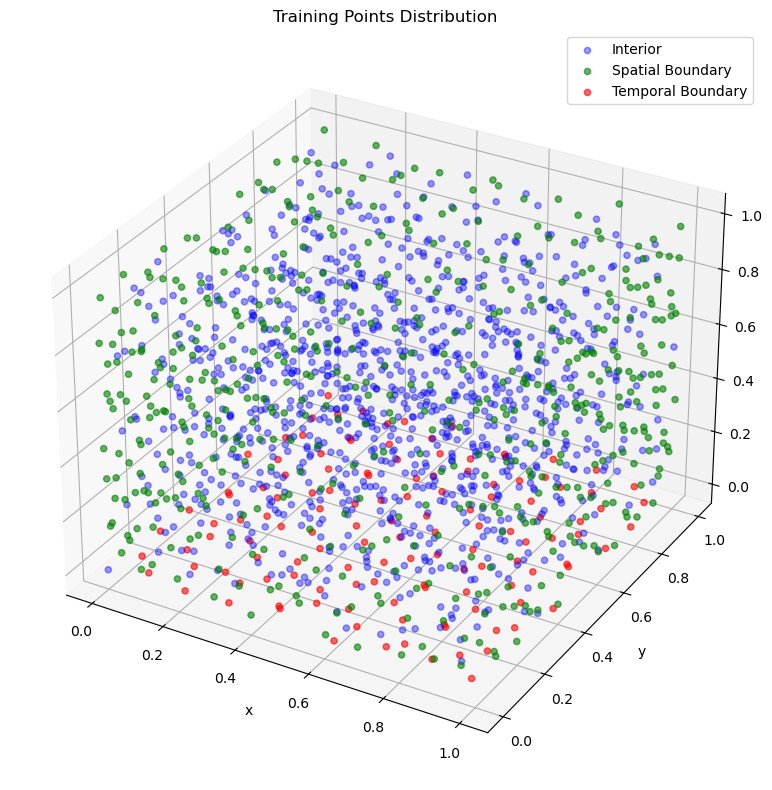

In [5]:
model.plot_training_points()

In [13]:
model.fit(epochs = 1000, verbose=True)

Training using device cuda

Epoch 0 | Loss :  0.1230
Epoch 100 | Loss :  0.7996
Epoch 200 | Loss :  0.4119
Epoch 300 | Loss :  0.2911
Epoch 400 | Loss :  0.2342
Epoch 500 | Loss :  0.1978
Epoch 600 | Loss :  0.1716
Epoch 700 | Loss :  0.1521
Epoch 800 | Loss :  0.1372
Epoch 900 | Loss :  0.1255
Training complete


In [14]:
model.compute_mse()

0.02723417803645134

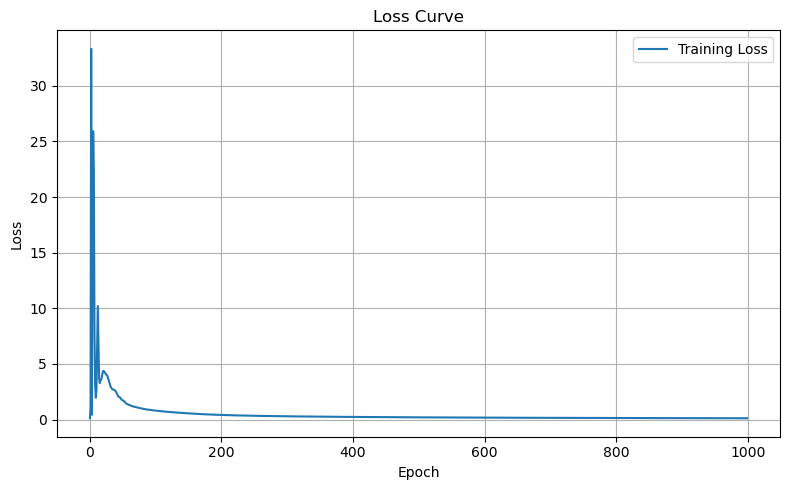

In [15]:
model.plot_loss()

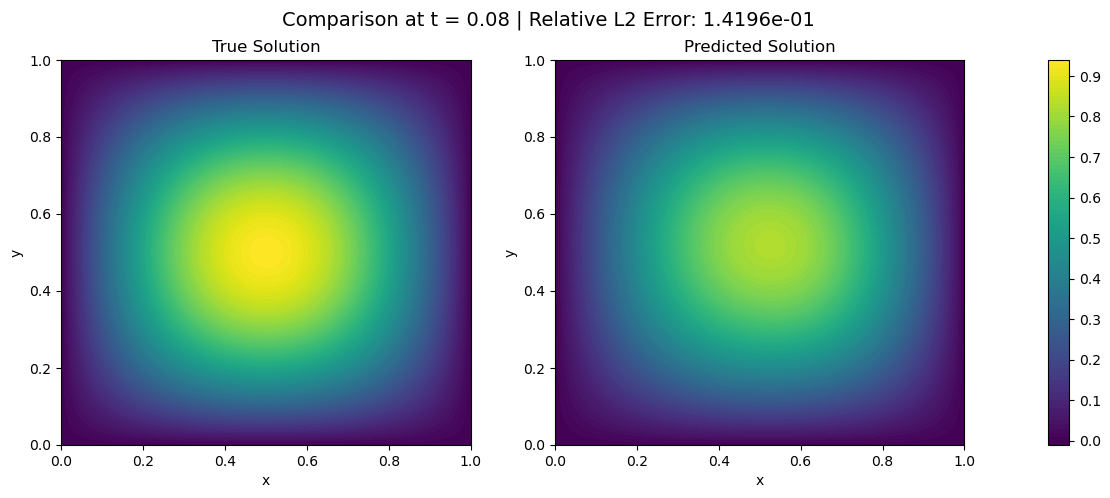

In [23]:
model.compare_predictions(t_fixed = 0.08)